In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

np.set_printoptions(suppress=True)

This code defines the object points and performs Direct Linear Transform (DLT) using numpy's linalg.lstsq function. It calculates the projection matrix, P, from the intrinsic camera matrix, K, and extrinsic matrix, E. Then it projects the object points to the image points and calculate the error between these two points. Finally, it plots the image with the object points and image points, showing the error.

This code is showing a basic example of camera calibration without using OpenCV libraries and it may need to be adjusted to match your specific use case. Additionally, you may have to use more complex camera model with more parameters for more accurate calibration.

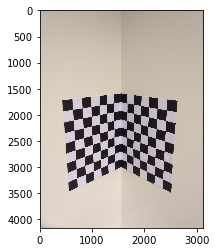

In [2]:
# Load the image

img=mpimg.imread('../images/Section-1/calib-object.jpg')
imgplot = plt.imshow(img)

In [3]:
# %matplotlib tk
# image_points = []
# fig = plt.figure(figsize=(20,30))

# def onclick(event):
#     ix, iy = event.xdata, event.ydata
#     print(ix, iy)
#     image_points.append([ix, iy])

# cid = fig.canvas.mpl_connect('button_press_event', onclick)

# imgplot = plt.imshow(img)
# plt.show()

In [4]:
image_coords= np.array([
        (982,2046),  (986,2228),  (1004,2396), (1009,2586), (1017,2745),
        (1925,2015), (1920,2192), (1920,2369), (1920,2541), (1916,2705), 
        (1287,2161), (1292,2316), (1292,2484), 
        (1783,2488), (1787,2329), (1787,2161), 
        (1544,2091), (1544,2245), (1544,2400), (1548,2555)
    ])


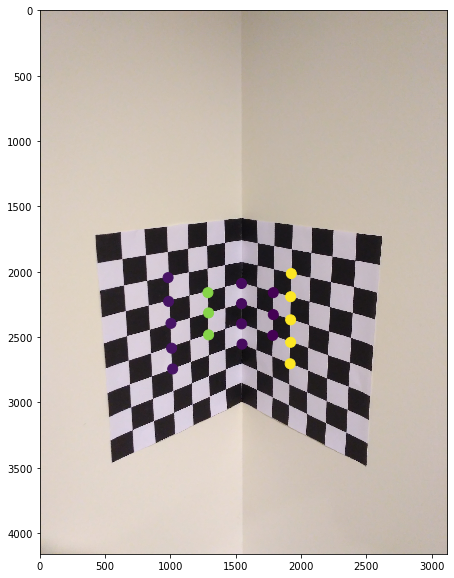

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))
imgplot = plt.imshow(img)

N = len(image_coords)

colors = np.random.rand(N)
colors[0:5] = colors[0]
colors[5:10] = colors[5]
colors[10:13] = colors[10]
colors[13:16] = colors[13]
colors[16:20] = colors[16]

area = (10 * np.ones(N))**2 

plt.scatter(image_coords[:,0], image_coords[:,1], c=colors, s=area)
plt.show()

In [6]:
# Keeping this for reference
# image_coords= np.array([
#         (982,2046),  (986,2228),  (1004,2396), (1009,2586), (1017,2745),
#         (1925,2015), (1920,2192), (1920,2369), (1920,2541), (1916,2705), 
#         (1287,2161), (1292,2316), (1292,2484), 
#         (1783,2488), (1787,2329), (1787,2161), 
#         (1544,2091), (1544,2245), (1544,2400), (1548,2555)
#     ])

In [7]:
# Respe
world_coords = np.array([
                    [0,2,4], [0,3,4], [0,4,4], [0,5,4], [0,6,4],
                    [3,2,0], [3,3,0], [3,4,0], [3,5,0], [3,6,0],
                    [0,3,2], [0,4,2], [0,5,2],
                    [2,5,0], [2,4,0], [2,3,0],
                    [0,3,0], [0,4,0], [0,5,0], [0,6,0]
                ])

In [8]:
# Makes a matrix homogeneous - appends one to the end of each row
def make_homo(no_homo):
    homo = np.hstack([no_homo, np.ones(no_homo.shape[0]).reshape(-1,1)])
    return homo

In [9]:
# small x denotes the image coordinates
x = make_homo(image_coords)

# big X denotes the world coordinates
X = make_homo(world_coords)

In [10]:
# idx_s = [1, 3, 5, 7, 9, 11, 13, 16, 18]
# x = x[idx_s]
# X = X[idx_s]

In [11]:
def Normalization(nd,x):
    '''
    Normalization of coordinates (centroid to the origin and mean distance of sqrt(2 or 3).
    Inputs:
     nd: number of dimensions (2 for 2D; 3 for 3D)
     x: the data to be normalized (directions at different columns and points at rows)
    Outputs:
     Tr: the transformation matrix (translation plus scaling)
     x: the transformed data
    '''

    x = np.asarray(x)
    m, s = np.mean(x,0), np.std(x)
    if nd==2:
        Tr = np.array([[s, 0, m[0]], [0, s, m[1]], [0, 0, 1]])
    else:
        Tr = np.array([[s, 0, 0, m[0]], [0, s, 0, m[1]], [0, 0, s, m[2]], [0, 0, 0, 1]])
        
    Tr = np.linalg.inv(Tr)
    x = np.dot( Tr, x.T )
    x = x.T

    return Tr, x

def DLT(x, X):
    # Txyz, X = Normalization(3, X)
    # Tuv, x = Normalization(2, x)
    
    A = []
    for i in range(x.shape[0]):
        A.append(
            [X[i][0], X[i][1], X[i][2], X[i][3],       0,       0,       0,       0, -x[i][0]*X[i][0], -x[i][0]*X[i][1], -x[i][0]*X[i][2], -x[i][0]]
            )
        A.append(
            [      0,       0,       0,       0, X[i][0], X[i][1], X[i][2], X[i][3], -x[i][1]*X[i][0], -x[i][1]*X[i][1], -x[i][1]*X[i][2], -x[i][1]]
            )
    
    A = np.asarray(A) * -1

    U,S,V = np.linalg.svd(A)
    
    # The column of V is the solution corresponding to the smallest singular value
    P = V[np.argmin(S)]

    # Reshape P to 3x4
    P = P.reshape(3,4)

    P = P/P[2, 3]

    
    # # Denormalization
    # H = V[np.argmin(S)]
    # H = np.dot( np.dot( np.linalg.pinv(Tuv), H ), Txyz );
    # H = H / H[-1,-1]
    # print(H.shape)
    # P = H.flatten(0)

    return P

In [12]:
P = DLT(x, X)

P

array([[  58.50258604,   18.05260495, -174.46801427, 1536.40092026],
       [ -46.99138289,  184.80949147,  -37.94606937, 1602.64889253],
       [  -0.03754177,    0.01042285,   -0.03270128,    1.        ]])

In [13]:
def project_points(P, X):
    x = P @ X.T
    x = x/x[2]
    return x.T[:, :2]

def get_projection_error(x, x_proj):
    return np.mean(np.linalg.norm(x_proj - x, axis=1))

In [14]:
x_proj = make_homo(project_points(P, X))
get_projection_error(x, x_proj)

3.528819280586448

In [15]:
x_proj - x

array([[ 0.69010413, -0.60607861,  0.        ],
       [ 5.36360295, -1.04329605,  0.        ],
       [-4.161392  ,  8.36440689,  0.        ],
       [-0.87814396, -8.24194942,  0.        ],
       [-0.78021765,  2.2723453 ,  0.        ],
       [-0.34175052,  1.35387576,  0.        ],
       [ 2.4726037 ,  2.65304292,  0.        ],
       [ 0.33599784, -0.04833699,  0.        ],
       [-1.75320026, -1.61711566,  0.        ],
       [ 0.20344887,  1.07401138,  0.        ],
       [-1.49796875, -6.26505184,  0.        ],
       [-1.73093311,  5.02897136,  0.        ],
       [ 2.93539201, -0.19020682,  0.        ],
       [ 1.66147811,  1.90486687,  0.        ],
       [-1.77090524, -3.44054911,  0.        ],
       [-1.19091403, -3.36884577,  0.        ],
       [-1.66777981,  0.67373139,  0.        ],
       [ 0.23019106,  3.15796131,  0.        ],
       [ 2.09055713,  1.54174394,  0.        ],
       [-0.08557496, -3.08368012,  0.        ]])

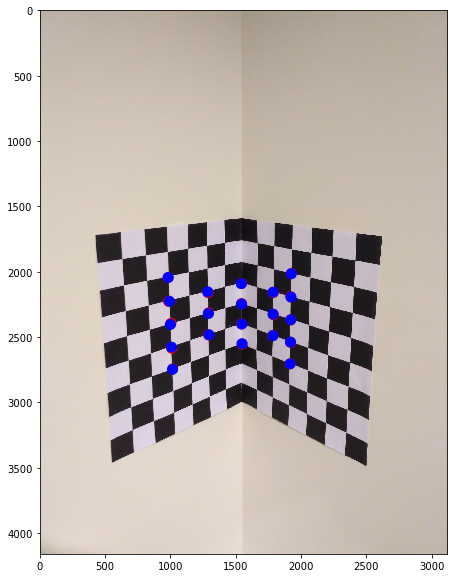

In [16]:
fig = plt.figure(figsize=(10,10))

imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (10 * np.ones(N))**2 

plt.scatter(x[:, 0], x[:,1], c = 'r', s = area)
plt.scatter(x_proj[:, 0], x_proj[:,1], c = 'b', s = area)
plt.show()

In [17]:
P

array([[  58.50258604,   18.05260495, -174.46801427, 1536.40092026],
       [ -46.99138289,  184.80949147,  -37.94606937, 1602.64889253],
       [  -0.03754177,    0.01042285,   -0.03270128,    1.        ]])

In [18]:
def get_properties(P):
    KR = P[:, :3]
    Kt = P[:, 3]

    K, R  = np.linalg.qr(KR)
    
    K = K/K[2, 2]
    K_inv = np.linalg.pinv(K)

    t = K_inv @ Kt
    return K, R, t

In [19]:
K, R, t = get_properties(P)

K, R, t

(array([[-0.77963664, -0.62623217,  0.00055302],
        [ 0.62623221, -0.77963679, -0.00011042],
        [ 0.0005003 ,  0.00026023,  1.        ]]),
 array([[ -75.03828389,  101.65917313,  112.25857092],
        [   0.        , -155.38937322,  138.84160358],
        [   0.        ,    0.        ,   -0.12499555]]),
 array([ -194.20352739, -2211.62675084,     1.6726979 ]))

In [20]:
def generate_projection_matrix(K, R, t):
    E = np.hstack([R, np.atleast_2d(t).T])
    I = K
    
    P = I @ E 
    return P

In [21]:
P2 = generate_projection_matrix(K, R, t)

P2

array([[  58.50259534,   18.05260782, -174.46804202, 1536.40092026],
       [ -46.99139036,  184.80952086,  -37.9460754 , 1602.64889253],
       [  -0.03754178,    0.01042286,   -0.03270129,    1.        ]])

In [22]:
P

array([[  58.50258604,   18.05260495, -174.46801427, 1536.40092026],
       [ -46.99138289,  184.80949147,  -37.94606937, 1602.64889253],
       [  -0.03754177,    0.01042285,   -0.03270128,    1.        ]])

In [23]:
x_reproj = make_homo(project_points(P2, X))
get_projection_error(x_reproj, x)

3.528829440460251

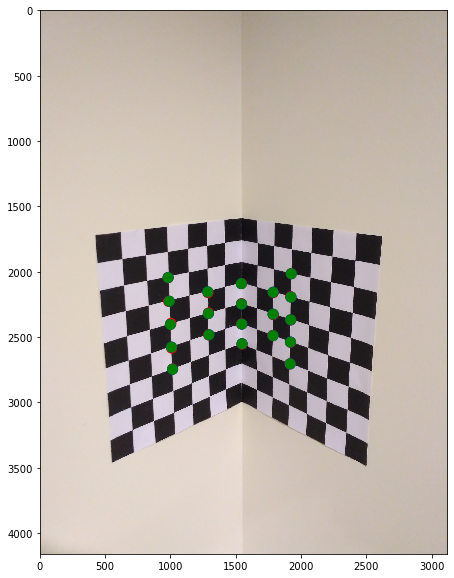

In [24]:
fig = plt.figure(figsize=(10,10))

imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (10 * np.ones(N))**2 

plt.scatter(x[:, 0], x[:,1], c = 'r', s = area)
plt.scatter(x_proj[:, 0], x_proj[:,1], c = 'b', s = area)
plt.scatter(x_reproj[:, 0], x_reproj[:,1], c = 'g', s = area)

plt.show()

In [25]:
def scale_world(world_coords, chess_block_shape):
    world_coords[:, 0] = world_coords[:, 0] * chess_block_shape[0]
    world_coords[:, 1] = world_coords[:, 1] * chess_block_shape[1]
    world_coords[:, 2] = world_coords[:, 2] * chess_block_shape[0]
    return world_coords

# Experiments

In [26]:
image_coords_og = np.array([
        (982,2046),  (986,2228),  (1004,2396), (1009,2586), (1017,2745),
        (1925,2015), (1920,2192), (1920,2369), (1920,2541), (1916,2705), 
        (1287,2161), (1292,2316), (1292,2484), 
        (1783,2488), (1787,2329), (1787,2161), 
        (1544,2091), (1544,2245), (1544,2400), (1548,2555)
    ])

world_coords_og = np.array([
                    [0,2,4], [0,3,4], [0,4,4], [0,5,4], [0,6,4],
                    [3,2,0], [3,3,0], [3,4,0], [3,5,0], [3,6,0],
                    [0,3,2], [0,4,2], [0,5,2],
                    [2,5,0], [2,4,0], [2,3,0],
                    [0,3,0], [0,4,0], [0,5,0], [0,6,0]
                ])

### Experiment 1

##### ChessBlock shape :- 2800mm x 2800mm -> 2.8cm x 2.8cm

In [27]:
world_coords = scale_world(world_coords_og, (2.8, 2.8))
image_coords = image_coords_og

In [28]:
x = make_homo(image_coords)
X = make_homo(world_coords)

# A -> Estimate Camaera Projection Matrix - P
P = DLT(x, X)

# B -> Estimate the reprojection error
x_proj = make_homo(project_points(P, X))
projection_error = get_projection_error(x, x_proj)

# C -> Estimate K, R, C
K, R, t = get_properties(P)
C = np.atleast_2d(t).T

In [29]:
print("A. Projection Matrix: \n", P)
print("-"*70)
print("B. Reprojection Error: \n", projection_error)
print("-"*70)
print("C. Camera Properties:")
print("K: \n", K)
print("R: \n", R)
print("C: \n", C)

A. Projection Matrix: 
 [[  30.91353357   -0.51670737  -56.16334382 1531.28569487]
 [  -5.05756266   53.59109179   -2.69610841 1638.70080068]
 [  -0.0085635    -0.0009443    -0.00707261    1.        ]]
----------------------------------------------------------------------
B. Reprojection Error: 
 15.587443117504273
----------------------------------------------------------------------
C. Camera Properties:
K: 
 [[-0.98687975 -0.16145698  0.00028034]
 [ 0.16145699 -0.98687979  0.00002032]
 [ 0.00027338  0.00006532  1.        ]]
R: 
 [[-31.32452029   9.16258396  54.99115712]
 [  0.         -52.80453732  11.72869792]
 [  0.           0.          -0.02287222]]
C: 
 [[-1246.61477001]
 [-1864.43725346]
 [    1.46258415]]
